# Optiver Realized Volatilty Prediction

Volatilty is one of the most prominent terms you’ll hear on any trading floor – and for good reason. In financial markets, volatility captures the amount of fluctuation in prices. High volatility is associated to periods of market turbulence and to large price swings, while low volatility describes more calm and quiet markets. For trading firms like Optiver, accurately predicting volatility is essential for the trading of options, whose price is directly related to the volatility of the underlying product.

As a leading global electronic market maker, Optiver is dedicated to continuously improving financial markets, creating better access and prices for options, ETFs, cash equities, bonds and foreign currencies on numerous exchanges around the world. Optiver’s teams have spent countless hours building sophisticated models that predict volatility and continuously generate fairer options prices for end investors. However, an industry-leading pricing algorithm can never stop evolving, and there is no better place than Kaggle to help Optiver take its model to the next level.

In the first three months of this competition, you’ll build models that predict short-term volatility for hundreds of stocks across different sectors. You will have hundreds of millions of rows of highly granular financial data at your fingertips, with which you'll design your model forecasting volatility over 10-minute periods. Your models will be evaluated against real market data collected in the three-month evaluation period after training.

Through this competition, you'll gain invaluable insight into volatility and financial market structure. You'll also get a better understanding of the sort of data science problems Optiver has faced for decades. We look forward to seeing the creative approaches the Kaggle community will apply to this ever complex but exciting trading challenge.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from sklearn.decomposition import PCA

import time
from keras import optimizers



import pandas as pd
import plotly.express as px
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

train.head()

Using TensorFlow backend.


,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [3]:
print("shape of the train data:",train.shape)

shape of the train data: (428932, 3)


In [4]:
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [20]:
import os
from sklearn.metrics import r2_score
import glob
# data
list_order_book_file_train = glob.glob('Data/book_train.parquet/*')
list_order_trade_file_train = glob.glob('Data/trade_train.parquet/*')
list_order_book_file_test = glob.glob('Data/book_test.parquet/*')
list_order_trade_file_test = glob.glob('Data/trade_test.parquet/*')

In [544]:
book_example = pd.read_parquet('Data/book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet('Data/trade_train.parquet/stock_id=0')
stock_id = '17'
#book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
##trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

In [547]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,17
1,5,46,1.002778,128,4,17
2,5,50,1.002818,55,1,17
3,5,57,1.003155,121,5,17
4,5,68,1.003646,4,1,17


In [286]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,38
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,38
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,38
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,38
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,38
...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,38
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,38
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,38
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,38


In [321]:
create_book_matrix(book_example,"ask_price1")

(3830, 600)

In [356]:
trade_example

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,38
1,5,46,1.002778,128,4,38
2,5,50,1.002818,55,1,38
3,5,57,1.003155,121,5,38
4,5,68,1.003646,4,1,38
...,...,...,...,...,...,...
123438,32767,471,0.998659,200,3,38
123439,32767,517,0.998515,90,1,38
123440,32767,523,0.998563,1,1,38
123441,32767,542,0.998803,90,4,38


In [258]:
book_example[book_example["time_id"]==5].shape

(302, 11)

In [525]:
missed_train_times = np.array([ 75,  80,  13, 100,  38])

time_ids = train["time_id"].unique()
train_len = int(time_ids.shape[0]*0.7)
time_index_1 = time_ids[:train_len]
time_index_2 = time_ids[train_len:]

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))



def create_matrix_data(df,feature,ids=time_ids):
    """
    create the matrix from the original book and trade data
    ARGS:
        df(dataframe): the original data to be converted to matrix
    Returns:
        mat_form- the matrix form of the dataframe
    """
    # used groupby to extract the time_id and seconds_in_bucket with log_return values
    
    
    book_mat = df.groupby(['time_id', 'seconds_in_bucket'])[feature].max().unstack()
    
    missed_time_ids = np.setdiff1d(ids,book_mat.index)
    all_nans = np.empty((book_mat.shape[1],))
    all_nans[:]=np.nan
    if len(missed_time_ids)!=0:
        for i in missed_time_ids:
            fill_missed = pd.DataFrame(all_nans,columns=[i]).T
            book_mat = pd.concat([book_mat,fill_missed]).sort_index()
            
    book_mat = book_mat.fillna(method="ffill",axis=1).fillna(method = "backfill",axis=1)
    
    return book_mat

def scale_data(df_matrix):
    """
    scale data for using in deep learning algorithms(LSTM) using MinMaxScaler
    
    ARGS:
        df_matrix- numpy ndarray 
    Returns:
        scaled_data- numpy array of scaled data
    """
    scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(df_matrix)
    
    return scaled_data

def fill_train(stock_ids=missed_train_times,time_ids = time_ids):
    
    merged_df = train.copy()
    for stock_id in stock_ids:
        
        stock_time_ids = train[train["stock_id"]==stock_id]["time_id"].unique()
        missed_time_ids = np.setdiff1d(time_ids,stock_time_ids)
    
        for i in missed_time_ids:
            df_1 = pd.DataFrame([stock_id,i,np.nan],train.columns).T
            merged_df = pd.concat([df_1,merged_df]).sort_values(by = ["stock_id","time_id"]).reset_index(drop = True)
            
    
    merged_df.stock_id = merged_df.stock_id.astype(int)
    merged_df.time_id = merged_df.time_id.astype(int)
    
    merged_df = merged_df.fillna(method="ffill",axis=0).fillna(method = "backfill",axis=0)

    return merged_df

# fill missed values in train data with nans
train_filled = fill_train()

In [526]:
def add_return_features(df_book_data,df_trade_data):
    """
    Create the train and traget data from row input dataframe 
    Args:
        df(pandas dataframe): the dataframe containing the row data
    Returns:
        train_data(dataframe)- the train data containing the log_returns of the book and trade data
        target_data(dataframe)- the target data created from the train data
    """
    
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+\
                df_book_data['ask_price1']* df_book_data['bid_size1']) \
                / (df_book_data['bid_size1']+ df_book_data['ask_size1'])
    df_book_data.loc[:,'log_return_1'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return);
    #df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    
    
    #book_matrix = create_book_matrix(df_book_data)
    # create trade matrix of log_returns 
    df_trade_data.loc[:,'log_return_2'] = log_return(df_trade_data['price']);
    #df_trade_data = df_trade_data[~df_trade_data['log_return'].isnull()]
    #trade_matrix = create_book_matrix(df_trade_data)


    # scale the data to prepare for machine learning
    
    
    return df_book_data,df_trade_data

In [ ]:
df = list_order_book_file_train = glob.glob('Data/book_train.parquet/*')

In [259]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,38
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,38
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,38
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,38
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,38
...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,38
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,38
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,38
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,38


In [363]:
trade_example

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,38
1,5,46,1.002778,128,4,38
2,5,50,1.002818,55,1,38
3,5,57,1.003155,121,5,38
4,5,68,1.003646,4,1,38
...,...,...,...,...,...,...
123438,32767,471,0.998659,200,3,38
123439,32767,517,0.998515,90,1,38
123440,32767,523,0.998563,1,1,38
123441,32767,542,0.998803,90,4,38


In [39]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [553]:
def build_train_data(book_file_path,trade_file_path):
    
    # create matrix for book_data log returns based on time_id and seconds in bucket as rows and columns
    df_book_data = pd.read_parquet(book_file_path)
    df_trade_data = pd.read_parquet(trade_file_path)
    #print(df_book_data.head())
    # scale the data to prepare for machine learning
    book_matrix,trade_matrix = add_return_features(df_book_data,df_trade_data)
    

    # create train and test data
    train_book = book_matrix
    train_trade = trade_matrix
    #train_df = train_book.merge(train_trade,on = ["time_id","seconds_in_bucket"])
    #print(train_df.shape)
    #print(train_book.head())
    # create target data from train data and scale it 
    stock_id = book_file_path.split('=')[1]
    
    target_data = train[train["stock_id"]==int(stock_id)]
    target_data = np.array(target_data.iloc[:,:]["target"]).reshape(-1,1)
    
    
    
    #combine trade and book data log_returns as one numpy array(tensor) with three dimensions 
    features_book = ["bid_price1","ask_price1","bid_price2","ask_price2","bid_size1","ask_size1","bid_size2",
                "ask_size2","wap","log_return_1"]
    
    features_trade = ["price","size","order_count","log_return_2"]
    
    dict_df = {}
    for feature in features_book:
        
        dict_df[feature] = create_matrix_data(train_book,feature)
        
    for feature in features_trade:
        
        dict_df[feature] = create_matrix_data(train_trade,feature)
        
    data_matrix = np.array([dict_df[feature].T for feature in dict_df]).T
    
    # define train and target and convert nans in trainX to numerical -1 
    trainX = data_matrix[:,:]
    #trainX = np.nan_to_num(trainX,nan=-1)
    trainY = target_data[:]
    
   
    return trainX,trainY

In [701]:
i = 0
for book_train,trade_train in zip(list_order_book_file_train,list_order_trade_file_train):
    
    stock_id = book_train.split('=')[1]
    
    
    print(stock_id)
    train_x,train_y = build_train_data(book_train,trade_train)
        
    i+=1
    print("stock number:",i)
        
    if (i==5):
        break
            

17
stock number: 1
28
stock number: 2
10
stock number: 3
26
stock number: 4
19
stock number: 5


In [552]:
train_x[0,1,:]

array([ 1.00118554e+00,  1.00158072e+00,  1.00104439e+00,  1.00175011e+00,
        1.00000000e+02,  2.00000000e+02,  6.30000000e+01,  1.00000000e+02,
        1.00131726e+00,  6.57743244e-05,  1.00158072e+00,  1.00000000e+02,
        2.00000000e+00, -2.11403938e-04])

In [913]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 100


def create_batch_data(X,y):
    
    train_size,valid_size,test_size = 0.6,0.2,0.2
    
    train_x = X[:3000,:,:]
    train_y = y[:3000]
    val_x = X[3001:3801,:,:]
    val_y = y[3001:3801]
    test_x = X[3001:3801,:,:]
    test_y = y[3001:3801]

    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
    test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

    # dataloaders

    # make sure the SHUFFLE your training data
    train_loader = DataLoader(train_data, batch_size=batch_size)
    valid_loader = DataLoader(valid_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    return train_loader,valid_loader,test_loader


### define the lstm layers 

In [898]:
import torch.nn as nn


class LSTM_Layers(nn.Module):
    def __init__(self,input_size,seq_len,output_size,hidden_dim,n_layers,drop_prob = 0.5):
        
        super(LSTM_Layers,self).__init__()
        
        self.output_size = output_size
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size,hidden_dim,n_layers,dropout = drop_prob,batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc = nn.Linear(hidden_dim*seq_len,output_size)
        
        
    def forward(self,x,hidden):
        
        x = x.float()
        batch_size,seq_len,_ = x.size()
        
    
        lstm_out,hidden = self.lstm(x,hidden)
        
        
        out = self.dropout(lstm_out)
        
        out = out.contiguous().view(batch_size,-1)
        
        out = self.fc(out)
        
        
        return out,hidden
    
    def init_hidden(self,batch_size):
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers,batch_size,self.hidden_dim).zero_(),\
        weight.new(self.n_layers,batch_size,self.hidden_dim).zero_())
        
        return hidden
        

### Define the model hyperparameters:

In [922]:
input_size = 14
output_size = 1
seq_len = 600
hidden_dim = 20
n_layers = 2

net = LSTM_Layers(input_size,seq_len,output_size,hidden_dim,n_layers)
print(net)

LSTM_Layers(
  (lstm): LSTM(14, 20, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12000, out_features=1, bias=True)
)


### Define criterion and Optimizer

In [923]:
lr = 0.0001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=lr)

## train data

In [924]:
epochs = 15

clip = 0.5

counter = 0
print_every = 30

i = 0 
stock_models = {}
for book_train,trade_train in zip(list_order_book_file_train,list_order_trade_file_train):
    
    
    stock_id = book_train.split("=")[1]
    
        
    #stock_id = book_train.split("=")[1]
    print(stock_id)    
    train_x,train_y = build_train_data(book_train,trade_train)
        
    scaler = StandardScaler()
    train_x_new = train_x.reshape(train_x.shape[0]*train_x.shape[1],-1)
    train_x_scaled = scaler.fit_transform(train_x_new)
    train_x_scaled = train_x_scaled.reshape(train_x.shape[0],train_x.shape[1],-1)
        
    scaler_1 = StandardScaler()
    train_y_scaled = scaler_1.fit_transform(train_y)
        
    
    train_loader,valid_loader,test_loader = create_batch_data(train_x_scaled,train_y_scaled)
        
    
        # train the data 
    net.train()
    
    losses_1 = []
    val_losses_1 = []
    for e in range(epochs):
            
            h = net.init_hidden(batch_size)
            losses = []
            for inputs,targets in train_loader:
                
                counter +=1
                
                
                h = tuple([each.data for each in h])
                
                net.zero_grad()
                
                output,h = net(inputs,h)
                
                loss = criterion(output,targets.float())
                loss.backward()
                
                nn.utils.clip_grad_norm_(net.parameters(),clip)
                optimizer.step()
                
                losses.append(loss.item())
                
                if counter%print_every == 0:
                    val_h = net.init_hidden(batch_size)
                    val_losses = []
                    net.eval()
                    for inputs,targets in valid_loader:
                        
                        val_h = tuple([each.data for each in val_h])
                        
                        
                        output,val_h = net(inputs,val_h)
                       
                        val_loss = criterion(output,targets.float())
                        
                        val_losses.append(val_loss.item())
                        
                    val_losses_1.append(np.mean(val_losses))
                    losses_1.append(np.mean(losses))
                    net.train()
                    print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
                    
            
        
    i+=1
    print("stock number:",i)
    stock_models[stock_id] = net
    if (i==1):
        break
    
        

17
Epoch: 1/15... Step: 30... Loss: 1.211177... Val Loss: 0.888600
Epoch: 2/15... Step: 60... Loss: 1.008592... Val Loss: 0.726620
Epoch: 3/15... Step: 90... Loss: 0.679826... Val Loss: 0.524289
Epoch: 4/15... Step: 120... Loss: 0.497422... Val Loss: 0.429681
Epoch: 5/15... Step: 150... Loss: 0.412732... Val Loss: 0.398356
Epoch: 6/15... Step: 180... Loss: 0.377552... Val Loss: 0.367918
Epoch: 7/15... Step: 210... Loss: 0.345282... Val Loss: 0.339868
Epoch: 8/15... Step: 240... Loss: 0.317890... Val Loss: 0.312744
Epoch: 9/15... Step: 270... Loss: 0.265885... Val Loss: 0.289255
Epoch: 10/15... Step: 300... Loss: 0.263800... Val Loss: 0.268647
Epoch: 11/15... Step: 330... Loss: 0.254681... Val Loss: 0.253617
Epoch: 12/15... Step: 360... Loss: 0.232258... Val Loss: 0.243093
Epoch: 13/15... Step: 390... Loss: 0.228344... Val Loss: 0.236363
Epoch: 14/15... Step: 420... Loss: 0.217955... Val Loss: 0.234613
Epoch: 15/15... Step: 450... Loss: 0.199435... Val Loss: 0.229398
stock number: 1


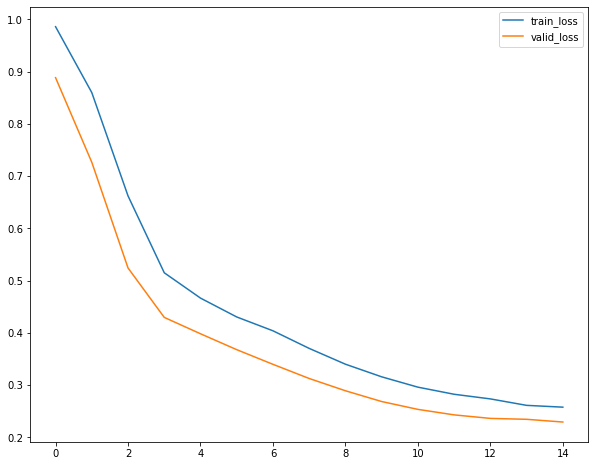

In [925]:
plt.figure(figsize = (10,8))
plt.plot(losses_1, label= "train_loss")
plt.plot(val_losses_1, label = "valid_loss")
plt.legend()

In [769]:
true_vals.shape

(750,)

In [625]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


In [927]:
test_losses = []

net.eval()

h = net.init_hidden(batch_size)

preds = []
true_vals = []
for inputs,targets in test_loader:
    
    h = tuple([each.data for each in h])
    
    output,h = net(inputs,h)
    
    test_loss = criterion(output,targets)
    test_losses.append(test_loss.item())
    
    
    preds.append(output.detach().numpy())
    true_vals.append(targets.detach().numpy())

preds = np.array(preds).flatten()
true_vals = np.array(true_vals).flatten()
    
print("Test Loss {: .3f}".format(np.mean(test_losses)))

preds_rescaled = scaler_1.inverse_transform(preds.reshape(-1,1))
true_vals_rescaled = scaler_1.inverse_transform(true_vals.reshape(-1,1))
R2_score = r2_score(true_vals_rescaled,preds_rescaled)
rmspe_score = rmspe(true_vals_rescaled,preds_rescaled)

print("test r2 score  {:.3f}".format(R2_score))
print("test rmspe score {:.3f}".format(rmspe_score))


Test Loss  0.229
test r2 score  0.761
test rmspe score 0.361


In [928]:
i = 0
for book_train,trade_train in zip(list_order_book_file_train,list_order_trade_file_train):
    
    stock_id = book_train.split("=")[1]
    net_2 = stock_models[stock_id]
    
    train_x,train_y = build_train_data(book_train,trade_train)
    
    scaler = StandardScaler()
    train_x_new = train_x.reshape(train_x.shape[0]*train_x.shape[1],-1)
    train_x_scaled = scaler.fit_transform(train_x_new)
    train_x_scaled = train_x_scaled.reshape(train_x.shape[0],train_x.shape[1],-1)
        
    scaler_1 = StandardScaler()
    train_y_scaled = scaler_1.fit_transform(train_y)
    
    train_loader,valid_loader,test_loader = create_batch_data(train_x_scaled,train_y_scaled)
    
    test_losses = []

    net_2.eval()

    h = net_2.init_hidden(batch_size)

    preds = []
    true_vals = []
    for inputs,targets in test_loader:
    
        h = tuple([each.data for each in h])
    
        output,h = net_2(inputs,h)
    
        test_loss = criterion(output,targets)
        test_losses.append(test_loss.item())
    
    
        preds.append(output.detach().numpy())
        true_vals.append(targets.detach().numpy())

    preds = np.array(preds).flatten()
    true_vals = np.array(true_vals).flatten()
    
    print("Test Loss {: .3f}".format(np.mean(test_losses)))

    preds_rescaled = scaler_1.inverse_transform(preds)
    true_vals_rescaled = scaler_1.inverse_transform(true_vals)
    R2_score = r2_score(true_vals_rescaled,preds_rescaled)
    rmspe_score = rmspe(true_vals_rescaled,preds_rescaled)

    print("stock id {}".format(stock_id))
    print("test r2 score  {:.3f}".format(R2_score))
    print("test rmspe score {:.3f}".format(rmspe_score))

    i +=1
    if (i==20):
        break
    

Test Loss  0.229
stock id 17
test r2 score  0.761
test rmspe score 0.361


KeyError: '28'